# EECS 498-007/598-005 Assignment 2-1: Linear Classifiers

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Hello WORLD, #XXXXXXXX

## Install starter code
We will continue using the utility functions that we've used for Assignment 1: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.

In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-bk7yb1vk
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-bk7yb1vk
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-cp36-none-any.whl size=10323 sha256=f2db496c117f107440405f6b48a06ed914c378e8e58b7110d7bbd1cd242fc4e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-f8oerykt/wheels/63/d1/27/a208931527abb98d326d00209f46c80c9d745851d6a1defd10
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [0]:
from __future__ import print_function
from __future__ import division

import torch
import coutils
import random
import time
import math
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Starting in this assignment, we will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

In [3]:
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


Now, we will load CIFAR10 dataset, with normalization.

In this notebook we will use the **bias trick**: By adding an extra constant feature of ones to each image, we avoid the need to keep track of a bias vector; the bias will be encoded as the part of the weight matrix that interacts with the constant ones in the input.

In the `two_layer_net.ipynb` notebook that follows this one, we will not use the bias trick.

0it [00:00, ?it/s]

170500096it [00:04, 34787298.05it/s]                               


Extracting ./cifar-10-python.tar.gz to .


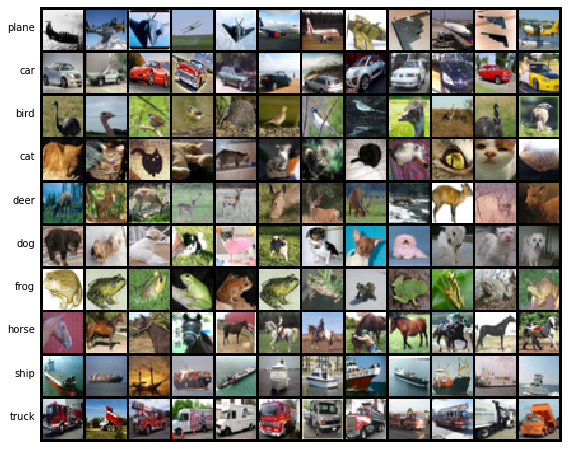

Train data shape:  torch.Size([49000, 3073])
Train labels shape:  torch.Size([49000])
Validation data shape:  torch.Size([1000, 3073])
Validation labels shape:  torch.Size([1000])
Test data shape:  torch.Size([10000, 3073])
Test labels shape:  torch.Size([10000])


In [4]:
def get_CIFAR10_data(validation_ratio = 0.02):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Move all the data to the GPU
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  X_train = X_train.reshape(X_train.shape[0], -1)
  X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Add bias dimension and transform into columns
  ones_train = torch.ones(X_train.shape[0], 1, device=X_train.device)
  X_train = torch.cat([X_train, ones_train], dim=1)
  ones_test = torch.ones(X_test.shape[0], 1, device=X_test.device)
  X_test = torch.cat([X_test, ones_test], dim=1)

  # 4. Carve out part of the training set to use for validation.
  # For random permutation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # Return the dataset as a dictionary
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

# Invoke the above function to get our data.
data_dict = get_CIFAR10_data()
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

For Softmax and SVM, we will analytically compute the gradient, as a sanity check.

In [0]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-7):
  """
  Utility function to perform numeric gradient checking. We use the centered
  difference formula to compute a numeric derivative:
  
  f'(x) =~ (f(x + h) - f(x - h)) / (2h)

  Rather than computing a full numeric gradient, we sparsely sample a few
  dimensions along which to compute numeric derivatives.

  Inputs:
  - f: A function that inputs a torch tensor and returns a torch scalar
  - x: A torch tensor giving the point at which to evaluate the numeric gradient
  - analytic_grad: A torch tensor giving the analytic gradient of f at x
  - num_checks: The number of dimensions along which to check
  - h: Step size for computing numeric derivatives
  """
  # fix random seed for 
  coutils.utils.fix_random_seed()

  for i in range(num_checks):
    
    ix = tuple([random.randrange(m) for m in x.shape])
    
    oldval = x[ix].item()
    x[ix] = oldval + h # increment by h
    fxph = f(x).item() # evaluate f(x + h)
    x[ix] = oldval - h # increment by h
    fxmh = f(x).item() # evaluate f(x - h)
    x[ix] = oldval     # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error_top = abs(grad_numerical - grad_analytic)
    rel_error_bot = (abs(grad_numerical) + abs(grad_analytic) + 1e-12)
    rel_error = rel_error_top / rel_error_bot
    msg = 'numerical: %f analytic: %f, relative error: %e'
    print(msg % (grad_numerical, grad_analytic, rel_error))

## SVM Classifier

In this section, you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [0]:
def svm_loss_naive(W, X, y, reg):
  """
  Structured SVM loss function, naive implementation (with loops).

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples. When you implment the regularization over W, please DO NOT
  multiply the regularization term by 1/2 (no coefficient). 

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as torch scalar
  - gradient of loss with respect to weights W; a tensor of same shape as W
  """
  dW = torch.zeros_like(W) # initialize the gradient as zero

  # compute the loss and the gradient
  num_classes = W.shape[1]
  num_train = X.shape[0]
  loss = 0.0
  for i in range(num_train):
    scores = W.t().mv(X[i])
    correct_class_score = scores[y[i]]
    for j in range(num_classes):
      if j == y[i]:
        continue
      margin = scores[j] - correct_class_score + 1 # note delta = 1
      if margin > 0:
        loss += margin
        #######################################################################
        # TODO:                                                               #
        # Compute the gradient of the loss function and store it dW. (part 1) #
        # Rather that first computing the loss and then computing the         #
        # derivative, it is simple to compute the derivative at the same time #
        # that the loss is being computed.                                    #
        #######################################################################
        # Replace "pass" statement with your code
        dW[:, y[i]] -= X[i, :]
        dW[:,j] += X[i, :]
        #######################################################################
        #                       END OF YOUR CODE                              #
        #######################################################################
        

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
  loss /= num_train

  # Add regularization to the loss.
  loss += reg * torch.sum(W * W)

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it in dW. (part 2)    #
  #############################################################################
  # Replace "pass" statement with your code
  dW /= num_train
  dW += 2 * reg * W

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

Evaluate the naive implementation of the loss we provided for you. You will get around 9.000175.

In [7]:
# generate a random SVM weight tensor of small numbers
coutils.utils.fix_random_seed()
W = torch.randn(3073, 10, device=data_dict['X_val'].device) * 0.0001 

loss, grad = svm_loss_naive(W, data_dict['X_val'], data_dict['y_val'], 0.000005)
print('loss: %f' % (loss, ))

loss: 9.000433


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you (The relative errors should be less than `1e-6`).

In [8]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Use a random W and a minibatch of data from the val set for gradient checking
# For numeric gradient checking it is a good idea to use 64-bit floating point
# numbers for increased numeric precision; however when actually training models
# we usually use 32-bit floating point numbers for increased speed.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=0.0) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.034577 analytic: -0.034577, relative error: 1.088088e-07
numerical: 0.126951 analytic: 0.126951, relative error: 5.721190e-08
numerical: -0.068597 analytic: -0.068597, relative error: 1.195002e-07
numerical: 0.025717 analytic: 0.025717, relative error: 4.062602e-08
numerical: 0.048266 analytic: 0.048266, relative error: 1.932111e-07
numerical: 0.052260 analytic: 0.052260, relative error: 1.179863e-07
numerical: 0.096133 analytic: 0.096133, relative error: 1.389181e-07
numerical: 0.032702 analytic: 0.032702, relative error: 1.787458e-07
numerical: -0.117158 analytic: -0.117158, relative error: 7.364778e-08
numerical: -0.154093 analytic: -0.154093, relative error: 1.236371e-07


Let's do the gradient check once again with regularization turned on. (You didn't forget the regularization gradient, did you?)

You should see relative errors less than `1e-5`.

In [9]:
# Use a minibatch of data from the val set for gradient checking
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
batch_size = 64
X_batch = data_dict['X_val'][:64].double()
y_batch = data_dict['y_val'][:64]

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W.double(), X_batch, y_batch, reg=1e3) 

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should
# match almost exactly along all dimensions.
f = lambda w: svm_loss_naive(w, X_batch, y_batch, reg=1e3)[0]
grad_numerical = grad_check_sparse(f, W.double(), grad)

numerical: -0.121624 analytic: -0.121624, relative error: 3.509551e-08
numerical: 0.020923 analytic: 0.020923, relative error: 3.331613e-07
numerical: -0.076604 analytic: -0.076604, relative error: 1.173771e-07
numerical: 0.256069 analytic: 0.256069, relative error: 8.151044e-09
numerical: -0.330089 analytic: -0.330089, relative error: 2.561535e-08
numerical: 0.004713 analytic: 0.004713, relative error: 1.481242e-06
numerical: 0.101968 analytic: 0.101968, relative error: 1.098650e-07
numerical: 0.097235 analytic: 0.097235, relative error: 6.655515e-08
numerical: -0.117112 analytic: -0.117112, relative error: 8.427538e-08
numerical: -0.257260 analytic: -0.257260, relative error: 7.655009e-08


Now, let's implement vectorized version of SVM: `svm_loss_vectorized`. It should compute the same inputs and outputs as the naive version before, but it should involve **no explicit loops**.

In [0]:
def svm_loss_vectorized(W, X, y, reg):
  """
  Structured SVM loss function, vectorized implementation. When you implment 
  the regularization over W, please DO NOT multiply the regularization term by 
  1/2 (no coefficient). 

  Inputs and outputs are the same as svm_loss_naive.
  """
  loss = 0.0
  dW = torch.zeros_like(W) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  num_classes = W.shape[1]
  num_train = X.shape[0]
  scores = torch.mm(X, W)
  cc_i = [range(num_train), y]
  correct_class_score = scores[cc_i].view(-1, 1)
  margin = torch.max(torch.zeros_like(scores), 
                    scores - correct_class_score + 1)
  margin[cc_i] = 0
  loss = torch.sum(margin)
  loss /= num_train
  loss += reg * torch.sum(W * W)

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
  # Replace "pass" statement with your code
  mask = (margin > 0).float()
  mask[cc_i] -= torch.sum(mask, axis = 1)
  dW = torch.mm(X.t(), mask)
  dW /= num_train
  dW += 2 * reg * W

  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

  return loss, dW

Let's first check the speed and performance bewteen the non-vectorized and the vectorized version. You should see a speedup of more than 100x.

(Note: It may have some difference, but should be less than 1e-6)

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
#W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
#X_batch = data_dict['X_val'][:128].double()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).float()
X_batch = data_dict['X_val'][:128].float()

y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss: %e computed in %.2fms' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, _ = svm_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss: %e computed in %.2fms' % (loss_vec, ms_vec))

# The losses should match but your vectorized implementation should be much faster.
print('Difference: %.2e' % (loss_naive - loss_vec))
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss: 9.000142e+00 computed in 265.00ms
Vectorized loss: 9.000144e+00 computed in 5.29ms
Difference: -1.91e-06
Speedup: 50.06X


Then, let's compute the gradient of the loss function. We can check the difference of gradient as well. (The error should be less than 1e-6)

Now implement a vectorized version of the gradient computation in `svm_loss_vectorize` above. Run the cell below to compare the gradient of your naive and vectorized implementations. The difference between the gradients should be less than `1e-6`, and the vectorized version should run at least 100x faster.


In [12]:
# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.

# Use random weights and a minibatch of val data for gradient checking
coutils.utils.fix_random_seed()
#W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
#X_batch = data_dict['X_val'][:128].double()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).float()
X_batch = data_dict['X_val'][:128].float()

y_batch = data_dict['y_val'][:128]
reg = 0.000005

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('Naive loss and gradient: computed in %.2fms' % ms_naive)

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
_, grad_vec = svm_loss_vectorized(W, X_batch, y_batch, 0.000005)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('Vectorized loss and gradient: computed in %.2fms' % ms_vec)

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a tensor, so
# we use the Frobenius norm to compare them.
grad_difference = torch.norm(grad_naive - grad_vec, p='fro')
print('Gradient difference: %.2e' % grad_difference)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

Naive loss and gradient: computed in 258.31ms
Vectorized loss and gradient: computed in 1.09ms
Gradient difference: 8.81e-06
Speedup: 237.70X


Now that we have an efficient vectorized implementation of the SVM loss and its gradient, we can implement a training pipeline for linear classifiers.

Complete the implementation of the following function:


In [0]:
def train_linear_classifier(loss_func, W, X, y, learning_rate=1e-3, 
                            reg=1e-5, num_iters=100, batch_size=200, verbose=False):
  """
  Train this linear classifier using stochastic gradient descent.

  Inputs:
  - loss_func: loss function to use when training. It should take W, X, y
    and reg as input, and output a tuple of (loss, dW)
  - W: A PyTorch tensor of shape (D, C) giving the initial weights of the
    classifier. If W is None then it will be initialized here.
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c
    means that X[i] has label 0 <= c < C for C classes.
  - learning_rate: (float) learning rate for optimization.
  - reg: (float) regularization strength.
  - num_iters: (integer) number of steps to take when optimizing
  - batch_size: (integer) number of training examples to use at each step.
  - verbose: (boolean) If true, print progress during optimization.

  Returns: A tuple of:
  - W: The final value of the weight matrix and the end of optimization
  - loss_history: A list of Python scalars giving the values of the loss at each
    training iteration.
  """
  # assume y takes values 0...K-1 where K is number of classes
  num_classes = torch.max(y) + 1
  num_train, dim = X.shape
  if W is None:
    # lazily initialize W
    W = 0.000001 * torch.randn(dim, num_classes, device=X.device, dtype=X.dtype)

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for it in range(num_iters):
    X_batch = None
    y_batch = None
    #########################################################################
    # TODO:                                                                 #
    # Sample batch_size elements from the training data and their           #
    # corresponding labels to use in this round of gradient descent.        #
    # Store the data in X_batch and their corresponding labels in           #
    # y_batch; after sampling, X_batch should have shape (batch_size, dim)  #
    # and y_batch should have shape (batch_size,)                           #
    #                                                                       #
    # Hint: Use torch.randint to generate indices.                          #
    #########################################################################
    # Replace "pass" statement with your code
    batch_idxs = torch.randint(num_train, (batch_size, ))
    #batch_idxs = [i.item() for i in 
    #              torch.randint(num_train, (1, batch_size)).flatten()]
    X_batch = X[batch_idxs]
    y_batch = y[batch_idxs]
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################

    # evaluate loss and gradient
    loss, grad = loss_func(W, X_batch, y_batch, reg)
    loss_history.append(loss.item())

    # perform parameter update
    #########################################################################
    # TODO:                                                                 #
    # Update the weights using the gradient and the learning rate.          #
    #########################################################################
    # Replace "pass" statement with your code
    W -= learning_rate * grad
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################

    if verbose and it % 100 == 0:
      print('iteration %d / %d: loss %f' % (it, num_iters, loss))

  return W, loss_history

Once you have implemented the training function, run the following cell to train a linear classifier using some default hyperparameters:

(You should see a final loss close to 9.0, and your training loop should run in about two seconds)

In [14]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed()

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(svm_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=3e-11, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 9.000759
iteration 100 / 1500: loss 9.000790
iteration 200 / 1500: loss 9.000771
iteration 300 / 1500: loss 9.000764
iteration 400 / 1500: loss 9.000766
iteration 500 / 1500: loss 9.000767
iteration 600 / 1500: loss 9.000770
iteration 700 / 1500: loss 9.000748
iteration 800 / 1500: loss 9.000766
iteration 900 / 1500: loss 9.000761
iteration 1000 / 1500: loss 9.000764
iteration 1100 / 1500: loss 9.000766
iteration 1200 / 1500: loss 9.000779
iteration 1300 / 1500: loss 9.000757
iteration 1400 / 1500: loss 9.000749
That took 1.321196s


A useful debugging strategy is to plot the loss as a function of iteration number. In this case it seems our hyperparameters are not good, since the training loss is not decreasing very fast.



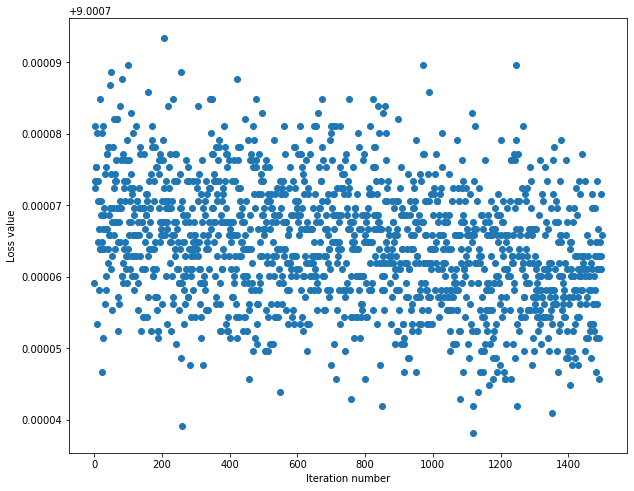

In [15]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's move on to the prediction stage:

In [0]:
def predict_linear_classifier(W, X):
  """
  Use the trained weights of this linear classifier to predict labels for
  data points.

  Inputs:
  - W: A PyTorch tensor of shape (D, C), containing weights of a model
  - X: A PyTorch tensor of shape (N, D) containing training data; there are N
    training samples each of dimension D.

  Returns:
  - y_pred: PyTorch int64 tensor of shape (N,) giving predicted labels for each
    elemment of X. Each element of y_pred should be between 0 and C - 1.
  """
  y_pred = torch.zeros(X.shape[0])
  ###########################################################################
  # TODO:                                                                   #
  # Implement this method. Store the predicted labels in y_pred.            #
  ###########################################################################
  # Replace "pass" statement with your code
  scores = torch.mm(X, W)
  y_pred = scores.argmax(dim = 1)
    ###########################################################################
  #                           END OF YOUR CODE                              #
  ###########################################################################
  return y_pred

Then, let's evaluate the performance our trained model on both the training and validation set. You should see validation accuracy less than 10%.

In [17]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('Training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('Validation accuracy: %.2f%%' % val_acc)

Training accuracy: 10.24%
Validation accuracy: 10.20%


Unfortunately, the performance of our initial model is quite bad. To find a better hyperparamters, let's first modulize the functions that we've implemented.

In [0]:
# Note: We will re-use `LinearClassifier' in Softmax section
class LinearClassifier(object):
  
  def __init__(self):
    self.W = None
    
  def train(self, X_train, y_train, learning_rate=1e-3, reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):
    train_args = (self.loss, self.W, X_train, y_train, learning_rate, reg,
                  num_iters, batch_size, verbose)
    self.W, loss_history = train_linear_classifier(*train_args)
    return loss_history

  def predict(self, X):
    return predict_linear_classifier(self.W, X) 
  
  def loss(self, W, X_batch, y_batch, reg):
    """
    Compute the loss function and its derivative. 
    Subclasses will override this.

    Inputs:
    - W: A PyTorch tensor of shape (D, C) containing (trained) weight of a model.
    - X_batch: A PyTorch tensor of shape (N, D) containing a minibatch of N
      data points; each point has dimension D.
    - y_batch: A PyTorch tensor of shape (N,) containing labels for the minibatch.
    - reg: (float) regularization strength.

    Returns: A tuple containing:
    - loss as a single float
    - gradient with respect to self.W; an tensor of the same shape as W
    """
    pass
  def _loss(self, X_batch, y_batch, reg):
    self.loss(self.W, X_batch, y_batch, reg)

  
class LinearSVM(LinearClassifier):
  """ A subclass that uses the Multiclass SVM loss function """

  def loss(self, W, X_batch, y_batch, reg):
    return svm_loss_vectorized(W, X_batch, y_batch, reg)

Now, please use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment your best model found through cross-validation should achieve an accuracy of at least 37% on the validation set.

(Our best model got over 40% -- did you beat us?)

In [19]:
# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.
#learning_rates = [1e-5, 1e-4, 1e-3, 1e-2] # learning rate candidates, e.g. [1e-3, 1e-2, ...]
#regularization_strengths = [1e0, 1e1, 1e2, 1e3] # regularization strengths candidates e.g. [1e0, 1e1, ...]

learning_rates = [1e-4, 1e-3, 1e-2] # learning rate candidates, e.g. [1e-3, 1e-2, ...]
regularization_strengths = [0.05, 0.1, 0.25, 0.5] # regularization strengths candidates e.g. [1e0, 1e1, ...]

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# Replace "pass" statement with your code
X_train = data_dict['X_train'] 
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']

#num_iters = 100
num_iters = 5000
batch_size = 200
verbose = False
'''
lr 1.000000e-04 reg 1.000000e+00 train accuracy: 34.971428 val accuracy: 35.800001
lr 1.000000e-03 reg 1.000000e+00 train accuracy: 36.069387 val accuracy: 36.500001
lr 1.000000e-02 reg 1.000000e+00 train accuracy: 33.922449 val accuracy: 33.900002
            '''
for lr in learning_rates:
  for reg in regularization_strengths:
    lsvm = LinearSVM()
    loss_history = lsvm.train(X_train, y_train, 
                              learning_rate = lr, reg = reg, 
                              num_iters = num_iters, batch_size = batch_size, 
                              verbose = verbose)
    y_train_pred = lsvm.predict(data_dict['X_train'])
    train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
    print('Training accuracy: %.2f%%' % train_acc)
    y_val_pred = lsvm.predict(data_dict['X_val'])
    val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
    results[(lr, reg)] = train_acc, val_acc
    if val_acc > best_val:
      best_val = val_acc
      best_svm = lsvm
    
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
  train_accuracy, val_accuracy = results[(lr, reg)]
  print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
         lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training accuracy: 36.08%
Training accuracy: 35.95%
Training accuracy: 35.81%
Training accuracy: 35.55%
Training accuracy: 39.82%
Training accuracy: 39.59%
Training accuracy: 38.51%
Training accuracy: 37.28%
Training accuracy: 39.30%
Training accuracy: 38.69%
Training accuracy: 37.50%
Training accuracy: 35.89%
lr 1.000000e-04 reg 5.000000e-02 train accuracy: 36.077550 val accuracy: 37.500003
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 35.951018 val accuracy: 37.400001
lr 1.000000e-04 reg 2.500000e-01 train accuracy: 35.812244 val accuracy: 37.400001
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 35.548979 val accuracy: 36.100003
lr 1.000000e-03 reg 5.000000e-02 train accuracy: 39.818367 val accuracy: 39.900002
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 39.593875 val accuracy: 40.200001
lr 1.000000e-03 reg 2.500000e-01 train accuracy: 38.510203 val accuracy: 38.900003
lr 1.000000e-03 reg 5.000000e-01 train accuracy: 37.277550 val accuracy: 38.000003
lr 1.000000e-02 reg 5.00

Visualize the cross-validation results. You can use this as a debugging tool -- after examining the cross-validation results here, you may want to go back and rerun your cross-validation from above.

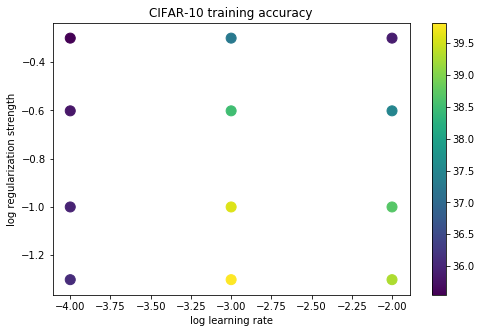

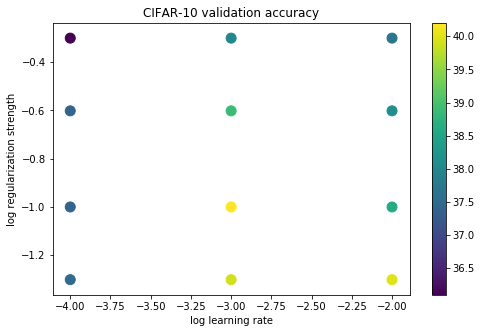

In [20]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Evaluate the best svm on test set. To get full credit for the assignment you should achieve a test-set accuracy above 35%.

(Our best was over 38% -- did you beat us?)

In [21]:
y_test_pred = best_svm.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.391500


Visualize the learned weights for each class. Depending on your choice of learning rate and regularization strength, these may or may not be nice to look at.

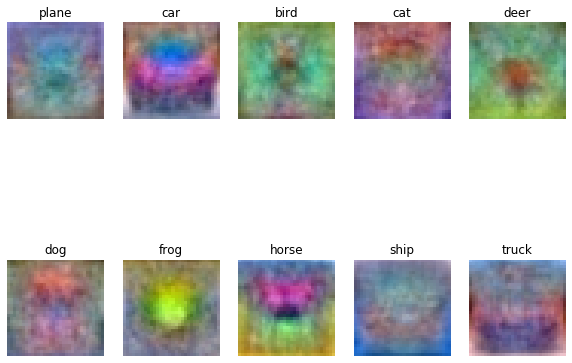

In [22]:
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])

## Softmax Classifier

Similar to the SVM, you will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights

First, let's start from implementing the naive softmax loss function with nested loops.


In [0]:
def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops).  When you implment 
  the regularization over W, please DO NOT multiply the regularization term by 
  1/2 (no coefficient). 

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A PyTorch tensor of shape (D, C) containing weights.
  - X: A PyTorch tensor of shape (N, D) containing a minibatch of data.
  - y: A PyTorch tensor of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an tensor of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability (Check Numeric Stability #
  # in http://cs231n.github.io/linear-classify/). Plus, don't forget the      #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  
  num_train = X.shape[0]
  num_classes = W.shape[1]

  for i in range(num_train):
    f = W.t().mv(X[i])
    # first shift the values of f so that the highest number is 0:
    f -= torch.max(f)
    fe = torch.exp(f)
    se = torch.sum(fe)
    loss += - f[y[i]] + torch.log(se)

    for j in range(num_classes):
      if j == y[i]:
        dW[:, j] -= X[i]
      dW[:, j] += fe[j] * X[i] / se

  dW /= num_train
  dW += 2 * reg * W

  loss /= num_train
  loss += reg * torch.sum(W * W)
  
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

As a sanity check to see whether we have implemented the loss correctly, run the softmax classifier with a small random weight matrix and no regularization. You should see loss near log(10) = 2.3

In [24]:
# Generate a random softmax weight tensor and use it to compute the loss.
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

# As a rough sanity check, our loss should be something close to log(10.0).
print('loss: %f' % loss)
print('sanity check: %f' % (math.log(10.0)))

loss: 2.302600
sanity check: 2.302585


Next, we use gradient checking to debug the analytic gradient of our naive softmax loss function. If you've implemented the gradient correctly, you should see relative errors less than `1e-6`.


In [25]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg=0.0)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg=0.0)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.008387 analytic: 0.008387, relative error: 1.366389e-07
numerical: 0.009227 analytic: 0.009227, relative error: 4.675665e-07
numerical: -0.002471 analytic: -0.002471, relative error: 1.105243e-06
numerical: -0.003144 analytic: -0.003144, relative error: 6.867327e-08
numerical: 0.006011 analytic: 0.006011, relative error: 4.374507e-07
numerical: 0.005936 analytic: 0.005936, relative error: 2.962140e-07
numerical: 0.015703 analytic: 0.015703, relative error: 1.243554e-07
numerical: 0.006452 analytic: 0.006452, relative error: 1.699042e-07
numerical: -0.015533 analytic: -0.015533, relative error: 1.855339e-07
numerical: -0.010170 analytic: -0.010170, relative error: 7.997548e-08


Let's perform another gradient check with regularization enabled. Again you should see relative errors less than `1e-6`.

In [26]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device).double()
reg = 10.0

X_batch = data_dict['X_val'][:128].double()
y_batch = data_dict['y_val'][:128]

loss, grad = softmax_loss_naive(W, X_batch, y_batch, reg)

f = lambda w: softmax_loss_naive(w, X_batch, y_batch, reg)[0]
grad_check_sparse(f, W, grad, 10)

numerical: 0.007517 analytic: 0.007517, relative error: 2.285944e-07
numerical: 0.008167 analytic: 0.008167, relative error: 5.558143e-07
numerical: -0.002551 analytic: -0.002551, relative error: 9.281690e-07
numerical: -0.000841 analytic: -0.000841, relative error: 2.692741e-07
numerical: 0.002228 analytic: 0.002228, relative error: 1.403682e-06
numerical: 0.005460 analytic: 0.005460, relative error: 2.421695e-07
numerical: 0.015762 analytic: 0.015762, relative error: 1.449829e-07
numerical: 0.007097 analytic: 0.007097, relative error: 1.473163e-07
numerical: -0.015532 analytic: -0.015532, relative error: 2.149296e-07
numerical: -0.011201 analytic: -0.011201, relative error: 7.318241e-08


Then, let's move on to the vectorized form

In [0]:
def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.  When you implment the 
  regularization over W, please DO NOT multiply the regularization term by 1/2 
  (no coefficient). 

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = torch.zeros_like(W)

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability (Check Numeric Stability #
  # in http://cs231n.github.io/linear-classify/). Don't forget the            #
  # regularization!                                                           #
  #############################################################################
  # Replace "pass" statement with your code
  num_train = X.shape[0]
  num_classes = W.shape[1]

  f = X.mm(W)
  # first shift the values of f so that the highest number is 0:
  f -= torch.max(f, dim = 1).values.view(-1, 1)
  fe = torch.exp(f)
  se = torch.sum(fe, dim = 1)
  idxs = [range(num_train), y]
  f_yi = f[idxs]
  loss_vec = torch.log(se) - f_yi
  loss = loss_vec.sum()

  loss /= num_train
  loss += reg * torch.sum(W * W)
  # gradient calculation
  ff = fe / se.view(-1, 1)
  ff[idxs] -= 1
  dW = torch.mm(X.t(), ff)

  dW /= num_train
  dW += 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in softmax_loss_vectorized. The two versions should compute the same results, but the vectorized version should be much faster.

The differences between the naive and vectorized losses and gradients should both be less than `1e-6`, and your vectorized implementation should be at least 100x faster than the naive implementation.

In [48]:
coutils.utils.fix_random_seed()
W = 0.0001 * torch.randn(3073, 10, device=data_dict['X_val'].device)
reg = 0.05

X_batch = data_dict['X_val'][:128]
y_batch = data_dict['y_val'][:128]

# Run and time the naive version
torch.cuda.synchronize()
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_naive = 1000.0 * (toc - tic)
print('naive loss: %e computed in %fs' % (loss_naive, ms_naive))

# Run and time the vectorized version
torch.cuda.synchronize()
tic = time.time()
loss_vec, grad_vec = softmax_loss_vectorized(W, X_batch, y_batch, reg)
torch.cuda.synchronize()
toc = time.time()
ms_vec = 1000.0 * (toc - tic)
print('vectorized loss: %e computed in %fs' % (loss_vec, ms_vec))

# we use the Frobenius norm to compare the two versions of the gradient.
loss_diff = (loss_naive - loss_vec).abs().item()
grad_diff = torch.norm(grad_naive - grad_vec, p='fro')
print('Loss difference: %.2e' % loss_diff)
print('Gradient difference: %.2e' % grad_diff)
print('Speedup: %.2fX' % (ms_naive / ms_vec))

naive loss: 2.302615e+00 computed in 158.534288s
vectorized loss: 2.302616e+00 computed in 1.071692s
Loss difference: 4.77e-07
Gradient difference: 3.29e-07
Speedup: 147.93X


Let's check that your implementation of the softmax loss is numerically stable.

If either of the following print `nan` then you should double-check the numeric stability of your implementations.

In [49]:
device = data_dict['X_train'].device
dtype = torch.float32
D = data_dict['X_train'].shape[1]
C = 10

W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_naive, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


W_ones = torch.ones(D, C, device=device, dtype=dtype)
W, loss_hist = train_linear_classifier(softmax_loss_vectorized, W_ones, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-8, reg=2.5e4,
                                       num_iters=1, verbose=True)


iteration 0 / 1: loss 768249984.000000
iteration 0 / 1: loss 768249984.000000


Now lets train a softmax classifier with some default hyperparameters:


In [50]:
# fix random seed before we perform this operation
coutils.utils.fix_random_seed(10)

torch.cuda.synchronize()
tic = time.time()

W, loss_hist = train_linear_classifier(softmax_loss_vectorized, None, 
                                       data_dict['X_train'], 
                                       data_dict['y_train'], 
                                       learning_rate=1e-10, reg=2.5e4,
                                       num_iters=1500, verbose=True)

torch.cuda.synchronize()
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 2.303346
iteration 100 / 1500: loss 2.303344
iteration 200 / 1500: loss 2.303344
iteration 300 / 1500: loss 2.303342
iteration 400 / 1500: loss 2.303342
iteration 500 / 1500: loss 2.303342
iteration 600 / 1500: loss 2.303342
iteration 700 / 1500: loss 2.303341
iteration 800 / 1500: loss 2.303339
iteration 900 / 1500: loss 2.303339
iteration 1000 / 1500: loss 2.303339
iteration 1100 / 1500: loss 2.303336
iteration 1200 / 1500: loss 2.303335
iteration 1300 / 1500: loss 2.303337
iteration 1400 / 1500: loss 2.303334
That took 1.119980s


Plot the loss curve:

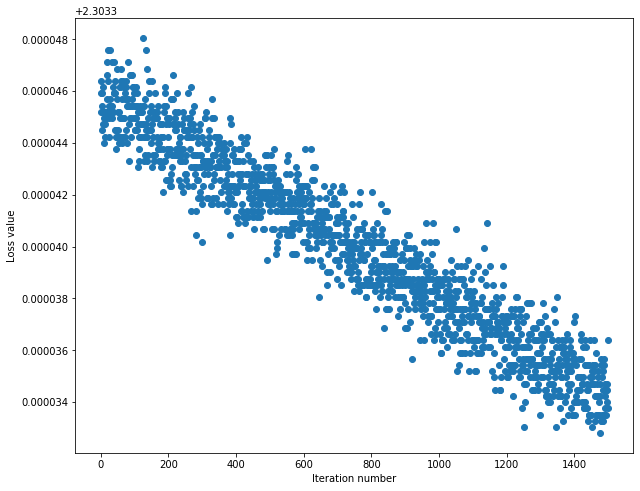

In [51]:
plt.plot(loss_hist, 'o')
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

Let's compute the accuracy of current model. It should be less than 10%.

In [52]:
# evaluate the performance on both the training and validation set
y_train_pred = predict_linear_classifier(W, data_dict['X_train'])
train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
print('training accuracy: %.2f%%' % train_acc)
y_val_pred = predict_linear_classifier(W, data_dict['X_val'])
val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
print('validation accuracy: %.2f%%' % val_acc)

training accuracy: 8.43%
validation accuracy: 8.00%


Now use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths.

To get full credit for the assignment, your best model found through cross-validation should achieve an accuracy above 0.37 on the validation set.

(Our best model was above 0.40 -- did you beat us?)

In [0]:
class Softmax(LinearClassifier):
  """ A subclass that uses the Softmax + Cross-entropy loss function """
  def loss(self, W, X_batch, y_batch, reg):
    return softmax_loss_vectorized(W, X_batch, y_batch, reg)

In [58]:
results = {}
best_val = -1
best_softmax = None

#learning_rates = [1e-5, 1e-4, 1e-3, 1e-2] # learning rate candidates
learning_rates = [1e-4, 5e-3, 1e-3, 1e-2] # learning rate candidates
#regularization_strengths = [1e-1, 5e-1, 5e0, 5e1, 5e2] # regularization strengths candidates
regularization_strengths = [5e-2, 1e-1, 5e-1, 5e0, 5e1] # regularization strengths candidates

# As before, store your cross-validation results in this dictionary.
# The keys should be tuples of (learning_rate, regularization_strength) and
# the values should be tuples (train_accuracy, val_accuracy)
results = {}

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be similar to the cross-validation that you used for the SVM,    #
# but you may need to select different hyperparameters to achieve good         #
# performance with the softmax classifier. Save your best trained softmax      #
# classifer in best_softmax.                                                   # 
################################################################################
# Replace "pass" statement with your code
X_train = data_dict['X_train'] 
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']

#num_iters = 1000
#num_iters = 5000
num_iters = 10000
batch_size = 200
verbose = False

for lr in learning_rates:
  for reg in regularization_strengths:
    sm = LinearSVM()
    loss_history = sm.train(X_train, y_train, 
                              learning_rate = lr, reg = reg, 
                              num_iters = num_iters, batch_size = batch_size, 
                              verbose = verbose)
    y_train_pred = sm.predict(data_dict['X_train'])
    train_acc = 100.0 * (data_dict['y_train'] == y_train_pred).float().mean().item()
    print('Training accuracy: %.2f%%' % train_acc)
    y_val_pred = sm.predict(data_dict['X_val'])
    val_acc = 100.0 * (data_dict['y_val'] == y_val_pred).float().mean().item()
    results[(lr, reg)] = train_acc, val_acc
    if val_acc > best_val:
      best_val = val_acc
      best_softmax = sm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

Training accuracy: 37.58%
Training accuracy: 37.50%
Training accuracy: 36.66%
Training accuracy: 31.50%
Training accuracy: 25.61%
Training accuracy: 40.32%
Training accuracy: 39.32%
Training accuracy: 36.45%
Training accuracy: 29.50%
Training accuracy: 23.52%
Training accuracy: 40.39%
Training accuracy: 39.78%
Training accuracy: 37.37%
Training accuracy: 31.83%
Training accuracy: 26.68%
Training accuracy: 40.17%
Training accuracy: 38.39%
Training accuracy: 36.52%
Training accuracy: 29.73%
Training accuracy: 23.38%
lr 1.000000e-04 reg 5.000000e-02 train accuracy: 37.581632 val accuracy: 38.500002
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 37.497959 val accuracy: 38.200003
lr 1.000000e-04 reg 5.000000e-01 train accuracy: 36.659181 val accuracy: 37.200001
lr 1.000000e-04 reg 5.000000e+00 train accuracy: 31.502038 val accuracy: 32.400000
lr 1.000000e-04 reg 5.000000e+01 train accuracy: 25.606123 val accuracy: 26.900002
lr 1.000000e-03 reg 5.000000e-02 train accuracy: 40.387753 val ac

Run the following to visualize your cross-validation results:

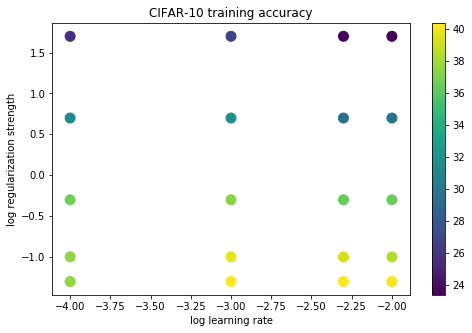

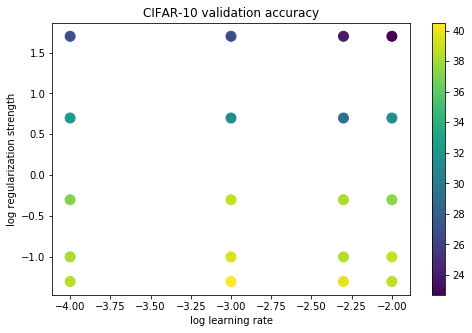

In [59]:
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap='viridis')
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.gcf().set_size_inches(8, 5)
plt.show()

Them, evaluate the performance of your best model on test set. To get full credit for this assignment you should achieve a test-set accuracy above 0.36.

(Our best was just over 0.40 -- did you beat us?)



In [60]:
y_test_pred = best_softmax.predict(data_dict['X_test'])
test_accuracy = torch.mean((data_dict['y_test'] == y_test_pred).float())
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.396000


Finally, let's visualize the learned weights for each class

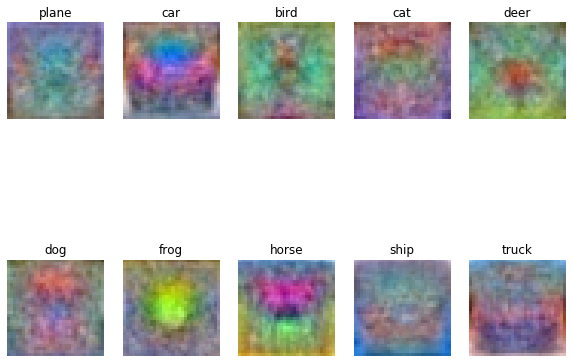

In [61]:
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(3, 32, 32, 10)
w = w.transpose(0, 2).transpose(1, 0)

w_min, w_max = torch.min(w), torch.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.type(torch.uint8).cpu())
  plt.axis('off')
  plt.title(classes[i])